<a href="https://colab.research.google.com/github/Gamebred94/Machine-Learning/blob/master/kmeans_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook walks through implementing KMeans from scratch—starting with a basic, inefficient version, then optimizing with broadcasting in pytorch, and finally accelerating with GPU support.

The core steps of KMeans are:

1. Set K clusters
2. assign initial centroids
3. calculate distance between each point to the centroid and reassign cluster
4. recompute centroid with mean of cluster
5. Repeat for N iterations

Generate random data

In [1]:
import math, torch, matplotlib.pyplot as plt
from functools import reduce
torch.manual_seed(24)
torch.set_printoptions(precision=3, linewidth=160, sci_mode=False)

from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
n_clusters = 6
n_samples = 250

In [3]:
initial_centroids = torch.rand(n_clusters,2)*70-35
initial_centroids

tensor([[ 18.510,  -8.746],
        [-29.744,   2.155],
        [ 32.622, -15.611],
        [-11.394,  27.371],
        [ -4.870, -13.368],
        [ -7.050,   1.282]])

In [4]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [5]:
slices = [sample(c) for c in initial_centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [6]:
centroids = torch.rand(n_clusters,2)*70-35
centroids

tensor([[ 25.467,  18.268],
        [ 21.343, -31.081],
        [ 19.534,  23.721],
        [ -1.747,   8.646],
        [  4.774,  32.914],
        [-13.331, -25.148]])

In [7]:
#Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

def plot_data(centroids, data, n_samples, ax=None):
  if ax is None:
    _,ax = plt.subplots()
  for i,centroid in enumerate(centroids):
      samples = data[i*n_samples:(i+1)*n_samples]
      ax.scatter(samples[:,0], samples[:,1], s=1)
      ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5) # big-marker X
      ax.plot(*centroid, markersize=5, marker="x", color="m", mew=2) # small-marker x


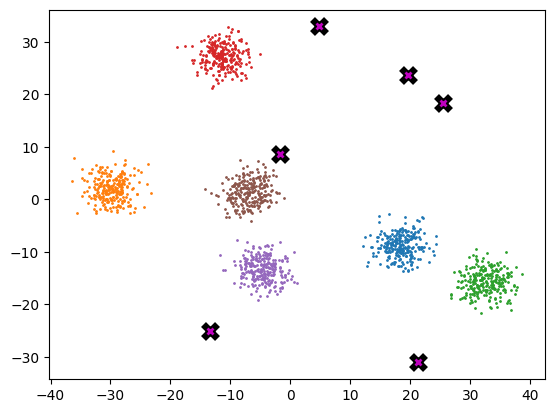

In [8]:
plot_data(centroids, data, n_samples)

In [9]:
X = data.clone()
x = X[:10]

centroids

tensor([[ 25.467,  18.268],
        [ 21.343, -31.081],
        [ 19.534,  23.721],
        [ -1.747,   8.646],
        [  4.774,  32.914],
        [-13.331, -25.148]])

Basic logic

In [ ]:
distances = [((c - x)**2).sum(1).sqrt() for c in centroids]
distances

[tensor([27.031, 25.897, 26.918, 28.765, 25.885, 28.604, 29.825, 29.713, 27.603, 29.937]),
 tensor([23.077, 23.927, 24.824, 22.400, 24.458, 25.536, 23.303, 20.404, 22.049, 20.557]),
 tensor([31.803, 30.905, 30.814, 32.989, 30.481, 31.706, 33.350, 34.508, 32.805, 34.516]),
 tensor([26.996, 27.370, 23.461, 25.686, 25.702, 21.207, 23.467, 28.603, 29.116, 27.822]),
 tensor([43.542, 43.089, 41.299, 43.745, 42.084, 40.798, 42.932, 46.033, 45.117, 45.694]),
 tensor([36.951, 38.396, 34.430, 34.091, 37.053, 31.377, 31.359, 35.600, 38.278, 34.639])]

In [ ]:
distances_tensor = torch.vstack(distances).t()
distances_tensor

tensor([[27.031, 23.077, 31.803, 26.996, 43.542, 36.951],
        [25.897, 23.927, 30.905, 27.370, 43.089, 38.396],
        [26.918, 24.824, 30.814, 23.461, 41.299, 34.430],
        [28.765, 22.400, 32.989, 25.686, 43.745, 34.091],
        [25.885, 24.458, 30.481, 25.702, 42.084, 37.053],
        [28.604, 25.536, 31.706, 21.207, 40.798, 31.377],
        [29.825, 23.303, 33.350, 23.467, 42.932, 31.359],
        [29.713, 20.404, 34.508, 28.603, 46.033, 35.600],
        [27.603, 22.049, 32.805, 29.116, 45.117, 38.278],
        [29.937, 20.557, 34.516, 27.822, 45.694, 34.639]])

In [ ]:
distances = torch.argmin(distances_tensor, dim=1)
distances

tensor([1, 1, 3, 1, 1, 3, 1, 1, 1, 1])

In [ ]:
x,x[distances == 1]

(tensor([[ 19.442,  -8.082],
         [ 20.594,  -7.166],
         [ 15.848,  -6.872],
         [ 16.774,  -9.152],
         [ 18.832,  -6.752],
         [ 12.383,  -7.168],
         [ 13.609,  -9.098],
         [ 19.243, -10.785],
         [ 21.388,  -9.032],
         [ 18.182, -10.769]]),
 tensor([[ 19.442,  -8.082],
         [ 20.594,  -7.166],
         [ 16.774,  -9.152],
         [ 18.832,  -6.752],
         [ 13.609,  -9.098],
         [ 19.243, -10.785],
         [ 21.388,  -9.032],
         [ 18.182, -10.769]]))

In [ ]:
x[distances == 1].mean(dim=0)

tensor([18.508, -8.855])

In [ ]:
updated_centroids = centroids
updated_centroids = [x[distances == k].mean(dim=0) if len(x[distances == k]) > 0 else updated_centroids[k] for k in range(n_clusters)]
updated_centroids = torch.vstack(updated_centroids)

In [ ]:
updated_centroids

tensor([[ 25.467,  18.268],
        [ 18.508,  -8.855],
        [ 19.534,  23.721],
        [ 14.116,  -7.020],
        [  4.774,  32.914],
        [-13.331, -25.148]])

In [14]:
def one_update():
  global centroids
  distances = [((c - X)**2).sum(1).sqrt() for c in centroids]
  distances_tensor = torch.vstack(distances).t()
  distances = torch.argmin(distances_tensor, dim=1)
  centroids = torch.stack([X[distances == k].mean(dim=0)
                      if len(X[distances == k]) > 0
                      else centroids[k]
                      for k in range(len(centroids))]
                      )

In [15]:
def kmeans(iterations=10):
  global centroids
  for n in range(iterations):
    old_cents = centroids
    one_update()
    new_cents = centroids
    if torch.equal(old_cents,new_cents):
      print(f"No more updates after {n} iterations...")
      break


In [21]:
%time _ = kmeans()

No more updates after 6 iterations...
CPU times: user 8.02 ms, sys: 1.91 ms, total: 9.93 ms
Wall time: 10.4 ms


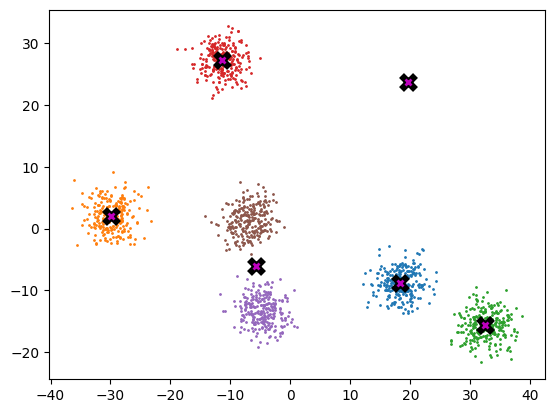

In [22]:
plot_data(centroids, data, n_samples)

In [23]:
centroids = tensor(
       [[ 25.467,  18.268],
        [ 21.343, -31.081],
        [ 19.534,  23.721],
        [ -1.747,   8.646],
        [  4.774,  32.914],
        [-13.331, -25.148]])
centroids

tensor([[ 25.467,  18.268],
        [ 21.343, -31.081],
        [ 19.534,  23.721],
        [ -1.747,   8.646],
        [  4.774,  32.914],
        [-13.331, -25.148]])

In [19]:
def do_one(d): #d = frame
  if d: one_update()
  ax.clear()
  plot_data(centroids, X, n_samples, ax=ax)

In [20]:
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=10, interval=800, repeat=False)
plt.close()
HTML(ani.to_jshtml())

Using broadcasting instead of looping the centroids

In [ ]:
centroids.shape, X.shape

(torch.Size([6, 2]), torch.Size([1500, 2]))

In [ ]:
X[None,:].shape, centroids[:,None,].shape, (X[None,:] - centroids[:,None,]).shape

(torch.Size([1, 1500, 2]), torch.Size([6, 1, 2]), torch.Size([6, 1500, 2]))

In [24]:
def distance(X,centroids):
  return ((centroids[:,None,] - X[None,:])**2).sum(2).sqrt()

In [25]:
distance(X,centroids), distance(X,centroids).shape

(tensor([[27.030, 25.896, 26.918,  ..., 38.221, 37.601, 34.289],
         [23.077, 23.927, 24.824,  ..., 40.567, 42.451, 39.281],
         [31.803, 30.905, 30.815,  ..., 36.909, 35.864, 33.227],
         [26.996, 27.370, 23.461,  ..., 11.843, 10.273,  9.228],
         [43.541, 43.089, 41.299,  ..., 36.825, 35.014, 34.324],
         [36.950, 38.396, 34.430,  ..., 24.016, 25.928, 26.666]]),
 torch.Size([6, 1500]))

In [ ]:
# def one_update_optimised(dist_func):
#   distances_tensor = dist_func(X, centroids)
#   distances = torch.argmin(distances_tensor, dim=0)
#   updated_centroids = torch.stack([X[distances == k].mean(dim=0)
#                       if len(X[distances == k]) > 0
#                       else centroids[k]
#                       for k in range(len(centroids))]
#                       )
#   return updated_centroids

In [59]:
def one_update_optimised(dist_func, X):
  global centroids
  # Calculate the distance from each point to each centroid
  distances_tensor = dist_func(X, centroids)

  # Find the index of the closest centroid for each point
  distances = torch.argmin(distances_tensor, dim=0)

  # Initialize tensors to store the sum of points for each cluster and the count of points in each cluster
  sums = torch.zeros_like(centroids)
  counts = torch.bincount(distances, minlength=len(centroids))

  # Add each point to the sum of its assigned cluster
  sums.index_add_(0, distances, X)

  # Calculate the new centroids by dividing the sum by the count for each cluster
  # If a cluster is empty (count is 0), keep the old centroid
  updated_centroids = torch.where(counts.unsqueeze(1) > 0, sums / counts.unsqueeze(1), centroids)

  return updated_centroids

In [65]:
def kmeans(iterations=10):
  global centroids
  for n in range(iterations):
    updated_centroids = one_update_optimised(distance, X)
    if torch.equal(centroids,updated_centroids):
      print(f"No more updates after {n} iterations...")
      break
    centroids = updated_centroids
  return updated_centroids


In [66]:
centroids = tensor(
       [[ 25.467,  18.268],
        [ 21.343, -31.081],
        [ 19.534,  23.721],
        [ -1.747,   8.646],
        [  4.774,  32.914],
        [-13.331, -25.148]])

%time _ = kmeans()

No more updates after 6 iterations...
CPU times: user 6.34 ms, sys: 60 µs, total: 6.4 ms
Wall time: 6.72 ms


We are much faster!

Using a GPU with broadcasted version

In [29]:
torch.device(1)

device(type='cuda', index=1)

In [49]:
centroids = tensor(
       [[ 25.467,  18.268],
        [ 21.343, -31.081],
        [ 19.534,  23.721],
        [ -1.747,   8.646],
        [  4.774,  32.914],
        [-13.331, -25.148]])
centroids_gpu = centroids.cuda()
X_gpu = X.cuda()

In [67]:
def kmeans_gpu(X_gpu, centroids_gpu, iterations=10, bs=1024):

  n = len(X_gpu)

  for n_iter in range(iterations):
    old_centroids_gpu = centroids_gpu.clone()
    sums = torch.zeros_like(centroids_gpu) #sum of each cluster
    counts = torch.zeros(len(centroids_gpu), dtype=torch.long, device='cuda') #count of each cluster

    for i in range(0, n, bs):
      s = slice(i, min(i+bs,n))
      X_batch = X_gpu[s]

      # Calculate the distance from each point in the batch to each centroid
      distances_tensor = distance(X_batch, centroids_gpu)

      # Find the index of the closest centroid for each point in the batch
      distances = torch.argmin(distances_tensor, dim=0)

      # Add each point in the batch to the sum of its assigned cluster
      sums.index_add_(0, distances, X_batch)

      # Count the number of points in each cluster for the batch
      counts.index_add_(0, distances, torch.ones_like(distances, dtype=torch.long, device='cuda'))


    # Calculate the new centroids by dividing the sum by the count for each cluster
    # If a cluster is empty (count is 0), keep the old centroid
    updated_centroids_gpu = torch.where(counts.unsqueeze(1) > 0, sums / counts.unsqueeze(1), centroids_gpu)

    # Check for convergence on the GPU
    if torch.equal(old_centroids_gpu, updated_centroids_gpu):
      print(f"No more updates after {n_iter} iterations...")
      break
    centroids_gpu = updated_centroids_gpu

  # Move the final centroids back to CPU for further analysis
  centroids = centroids_gpu.cpu()
  return centroids

In [68]:
%time _= kmeans_gpu(X_gpu, centroids_gpu, bs=1500)

CPU times: user 5.07 ms, sys: 0 ns, total: 5.07 ms
Wall time: 5.57 ms


In [69]:
%timeit -n 10 _= kmeans_gpu(X_gpu, centroids_gpu, bs=1500)

3.02 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


GPU speed-ups are more prominent in large datasets!